In [1]:
# Are subjects more likely to reproduce some features than others? *
# Are trained subjects more likely to reproduce game set features? ***
# Probability of missing a piece that is / is not part of a feature (or by # of features piece is part of)

In [1]:
import os

import numpy as np
import pandas as pd
import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import lib.exp4 as exp4
import lib.reconstruction.errors as errs
import lib.reconstruction.features as ftrs
import lib.reconstruction.neighbors as nbrs

import lib.utility_functions as uf
import lib.util.datatype_utilities as dtutils

# Config
sns.set_style('white')
sns.set_context('talk')

pd.set_option('display.max_columns', 40)

% matplotlib inline

/Users/gianni/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/gianni/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [24]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)
tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)
tidy['Position ID'] = tidy['Position ID'].map(int)

vals = ['Black Position', 'White Position', 'Is Real', 'Num Pieces']

board_set = tidy.pivot_table(index='Position ID', values=vals, aggfunc=lambda x: x.unique()[0])[vals]

In [25]:
def count_all_features(row):
    features = ['1100', '1010', '1001', '1110', '1101', '1111']
    bp = row['Black Position']
    wp = row['White Position']
    
    output_dict = {}
    for feature in features:
        bcount, wcount = ftrs._count_feature(bp, wp, feature)
        
        output_dict[feature + 'b'] = bcount
        output_dict[feature + 'w'] = wcount
        
    return output_dict

In [26]:
# def _detect_type_2_error(bi, bf, wi, wf):
#     final_empty = ((bf == '0') and (wf == '0')) 
#     original_not_empty = ((bi == '1') or (wi == '1'))
    
#     return int(original_empty and final_not_empty)

# def _detect_type_3_error(bi, bf, wi, wf):
#     b2w = ((bi == '1') and (wf == '1'))
#     w2b = ((wi == '1') and (bf == '1'))
    
#     return int(b2w or w2b)

# def count_all_errors(row):
#     bpi = row['Black Position']
#     bpf = row['Black Position (final)']
    
#     wpi = row['White Position']
#     wpf = row['White Position (final)']
    
    
#     type_2_errors = [
#         _detect_type_2_error(bi, bf, wi, wf)
#         for bi, bf, wi, wf in zip(bpi, bpf, wpi, wpf)
#     ]
    
#     type_3_errors = [
#         _detect_type_3_error(bi, bf, wi, wf)
#         for bi, bf, wi, wf in zip(bpi, bpf, wpi, wpf)
#     ]
    
#     return {'Type 2': type_2_errors, 'Type 3': type_3_errors}

errors_by_location_2 = tidy.apply(
    lambda x: errs.get_errors_per_location(x, errs.error_func_2), 
    axis=1
)
    
tidy['ebl2'] = errors_by_location_2

In [114]:
pos_grouped = tidy.groupby('Position ID', )
board_set['ebl2'] = pos_grouped.apply(lambda df: np.stack(df['ebl2'], axis=1).mean(axis=1))

In [62]:
num_grouped = board_set.groupby('Num Pieces')
mean_error_by_num_pieces = num_grouped.apply(lambda df: np.stack(df['ebl2'], axis=1).mean(axis=1))

In [66]:
board_set['ebl2'] = board_set.apply(
    lambda row: row['ebl2'] - mean_error_by_num_pieces[row['Num Pieces']],
    axis=1
)

In [115]:
# board_set = board_set.loc[pd.notnull(board_set['ebl2'])]
board_set['location_idx'] = np.tile(np.arange(36, dtype=np.uint8), [len(board_set), 1]).tolist()
board_set.head()

,Black Position,White Position,Is Real,Num Pieces,ebl2,location_idx,filtered_ebl,filtered_1110b,filtered_1110w
Position ID,,,,,,,,,
0,000000000010000000001000010100011000,000000000000101000010001000000100000,False,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.3026315789473684, 0.5153508771929824, 0.302...","[0.3026315789473684, 0.5153508771929824, 0.302...","[0.3026315789473684, 0.5153508771929824, 0.302..."
1,000101100000000000001010000000000100,000010010000010000010000000001000000,False,11,"[0.0, 0.0, 0.0, 0.15789473684210525, 0.1052631...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.11184210526315788, -0.010964912280701747, 0...","[0.11184210526315788, -0.010964912280701747, 0...","[0.11184210526315788, -0.010964912280701747, 0..."
2,000000000000110000000011100000100000,000110010001000000000000000000000100,False,11,"[0.0, 0.0, 0.0, 0.10526315789473684, 0.2368421...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.05921052631578947, 0.1206140350877193, 0.14...","[0.05921052631578947, 0.1206140350877193, 0.14...","[0.05921052631578947, 0.1206140350877193, 0.14..."
3,010010100000110000000000010000000000,000000000110000000000010000000101000,False,11,"[0.0, 0.23684210526315788, 0.0, 0.0, 0.1315789...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.21710526315789472, 0.015350877192982462, 0....","[0.21710526315789472, 0.015350877192982462, 0....","[0.21710526315789472, 0.015350877192982462, 0...."
4,001100000000100100000001000000010000,000010000000000000010110000010000000,False,11,"[0.0, 0.0, 0.13157894736842105, 0.105263157894...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.10087719298245613, 0.05921052631578947, 0.1...","[0.10087719298245613, 0.05921052631578947, 0.1...","[0.10087719298245613, 0.05921052631578947, 0.1..."


In [116]:
feature_count_df = pd.DataFrame(board_set.apply(count_all_features, axis=1).tolist(), index=board_set.index)

In [117]:
def filter_by_occupied(row, targ):
    ebl = row[targ]
    bp = row['Black Position']
    wp = row['White Position']
    
    filtered_ebl = []
    for i, (bi, wi) in enumerate(zip(bp, wp)):
        if bi == '1' or wi == '1':
            filtered_ebl.append(ebl[i])
            
    return filtered_ebl

In [142]:
# error_df = pd.DataFrame(tidy.apply(count_all_errors, axis=1).tolist())
sum_df = pd.concat([board_set, feature_count_df], axis=1)
sum_df = sum_df.loc[pd.notnull(sum_df['ebl2'])]

sum_df['filtered_ebl'] = sum_df.apply(lambda row: filter_by_occupied(row, 'ebl2'), axis=1)
for f in ['1111', '1110', '1101', '1100', '1010', '1001']:
    sum_df['filtered_{}b'.format(f)] = sum_df.apply(lambda row: filter_by_occupied(row, '{}b'.format(f)), axis=1)
    sum_df['filtered_{}w'.format(f)] = sum_df.apply(lambda row: filter_by_occupied(row, '{}w'.format(f)), axis=1)

In [157]:
# x = []
# for f in ['1110']: #, '1101', '1010', '1001', '1100', '1111']:
#     x.append(np.stack((sum_df['{}b'.format(f)] + sum_df['{}w'.format(f)]).values).flatten())

# for d in dummy_locs.T:
#     x.append(d)
  
# x = np.stack(x).T
# print(x.shape)
feature_list = ['1111', '1110', '1101', '1100', '1010', '1001']
x = []
for f in feature_list:
    xb = [loc_val for board in sum_df['filtered_{}b'.format(f)] for loc_val in board]
    xw = [loc_val for board in sum_df['filtered_{}w'.format(f)] for loc_val in board]
    x_ = np.stack(xb) + np.stack(xw)
    
    x.append(x_)
    
x = np.stack(x).T
y = np.stack([loc_val for board in sum_df['filtered_ebl'] for loc_val in board])

model = sm.Logit(y, x)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.569598
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1374
Method:                           MLE   Df Model:                            5
Date:                Mon, 20 Aug 2018   Pseudo R-squ.:                  -1.045
Time:                        17:28:08   Log-Likelihood:                -786.05
converged:                       True   LL-Null:                       -384.37
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.3767      0.642     -2.143      0.032      -2.636      -0.117
x2            -1.1694      0.196     -5.959      0.000      -1.554      -0.785
x3            -0.3388      0.167     -2.026      0.043      -0.667      -0.011
x4            -0.8147      0.111     -7.369      0.000      -1.031      -0.598
x5            -0.2343      0.098     -2.387      0.017      -0.427      -0.042
x6            -0.3169      0.137     -2.313      0.021      -0.585      -0.048
==============================================================================
"""

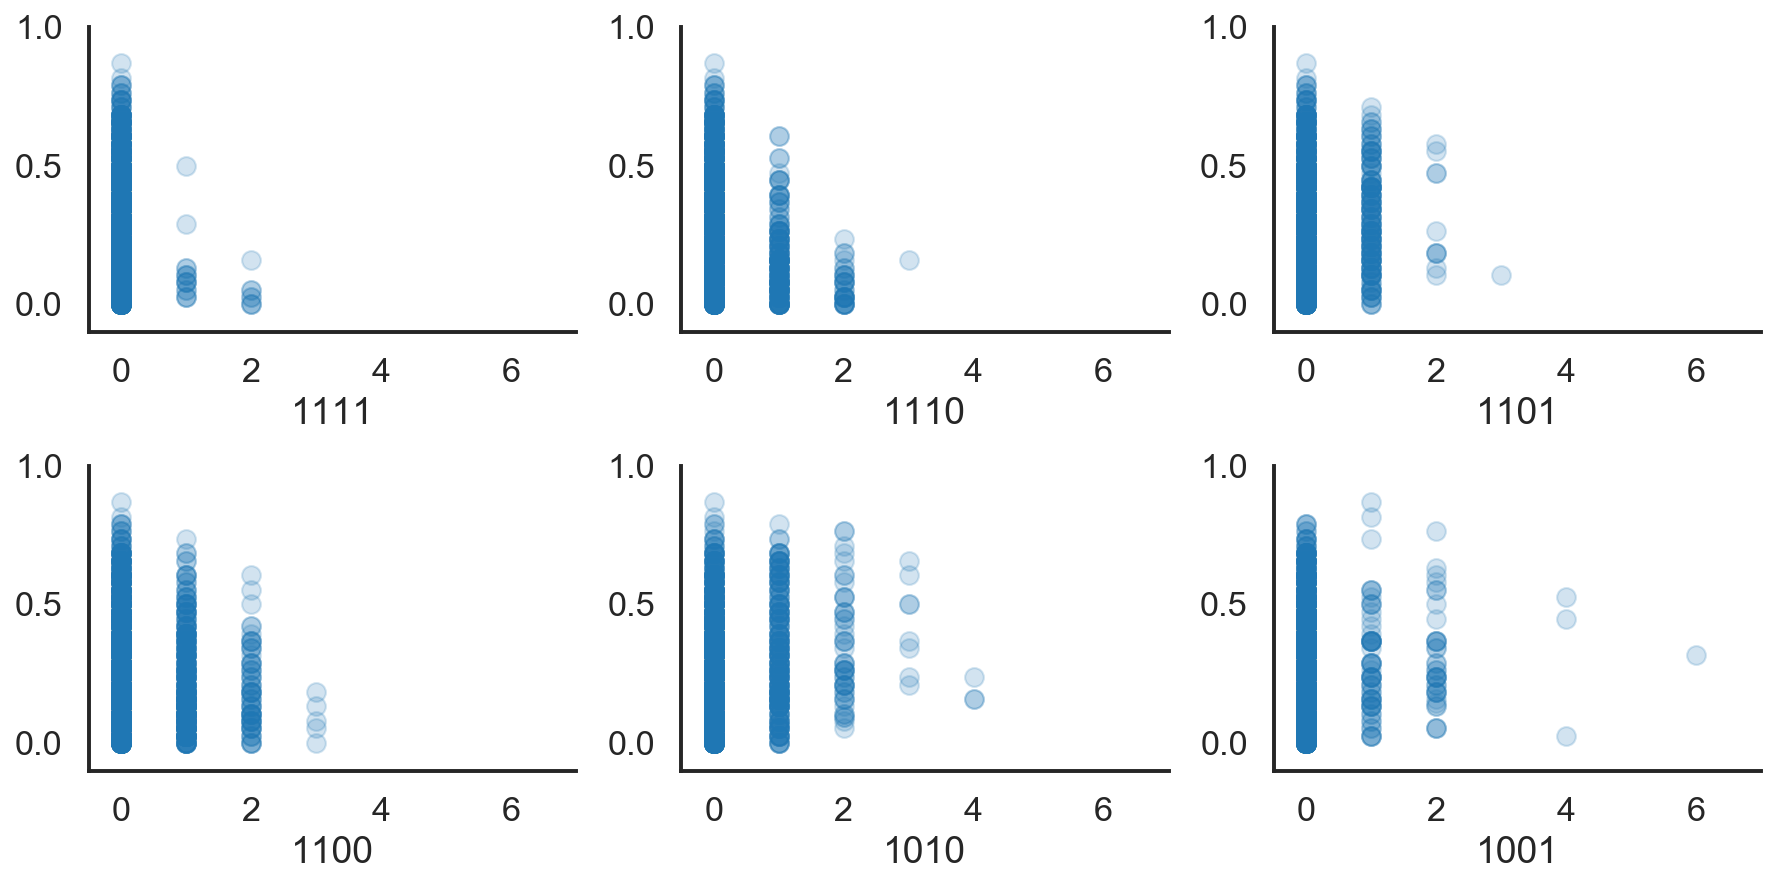

In [158]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), dpi=150)

for i in range(2):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(x[:, 3*i + j], y, marker='o', linestyle='none', alpha=.2)
        
        plt.setp(
            ax,
            xlabel=feature_list[3*i + j]
        )

# model_curve_x = np.arange(-3, 3, .1)[:, np.newaxis]
# model_curve_y = result.model.predict(result.params, model_curve_x)

# ax.plot(model_curve_x, model_curve_y)

# ax = axes[1]
# ax.plot(x[:, 1], y, marker='o', linestyle='none', alpha=.2)

# ax = axes[2]
# ax.plot(x[:, 2], y, marker='o', linestyle='none', alpha=.2)

plt.setp(
    axes, 
    xlim=[-.5, 7],
    ylim=[-.1, 1]
    
)

sns.despine()
fig.tight_layout()

In [7]:
def sum_features(row):
    
    counts = np.zeros(36, dtype=np.uint8)
    
    for name in row.index:
        if 'Type' not in name:

            counts += np.stack(row[name])
                
    return counts.tolist()

sum_df['all'] = sum_df.apply(sum_features, axis=1)

In [8]:
def bin_errors_by_num_features(row, error_type):
    type2 = row[error_type]
    feats = row['all']
    
    counts = {}
    for i, f in enumerate(feats):
        if f not in counts.keys():
            counts[f] = 0
            
        counts[f] += type2[i]
        
    return counts


def bin_errors_type2(row):
    return bin_errors_by_num_features(row, 'Type 2')


def bin_errors_type3(row):
    return bin_errors_by_num_features(row, 'Type 3')


def bin_features(row):
    idx = row.name
    bp = tidy.iloc[idx]['Black Position']
    wp = tidy.iloc[idx]['White Position']
    p = _add_position_strings(bp, wp)
    p = list(map(int, p))
    
    feats = row['all']
    
    counts = {}
    for i, f in enumerate(feats):
        if f not in counts.keys():
            counts[f] = 0
            
        counts[f] += p[i]
        
    return counts
    

type2_counts = pd.DataFrame(sum_df.apply(bin_errors_type2, axis=1).tolist()).fillna(0)
type3_counts = pd.DataFrame(sum_df.apply(bin_errors_type3, axis=1).tolist()).fillna(0)
feature_counts = pd.DataFrame(sum_df.apply(bin_features, axis=1).tolist()).fillna(0)

In [9]:
# Spearman: # features, # errors

In [10]:
type2_counts.sum(axis=0) / feature_counts.sum(axis=0)

0    0.258431
1    0.256140
2    0.261877
3    0.246600
4    0.146491
5    0.032895
6    0.131579
dtype: float64

In [11]:
sum_df.head()

,Type 2,Type 3,1001,1010,1100,1101,1110,1111,all
0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, ...","[1, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, ...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 2, 2, 4, 2, 1, 0, 0, 0, 1, 2, 2, 3, 2, ..."
1,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 1, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 2, 3, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, ..."


In [30]:
sum_df['1110b'].iloc[0].reshape([4, 9])

array([[0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0]], dtype=uint8)

In [12]:
dist2 = type2_counts.sum(axis=0) / feature_counts.sum(axis=0)
# for Type II/III errors, number of possible errors is limited by number of pieces
# so feature_counts is for each position the number of pieces
# with X features present

In [13]:
dist3 = type3_counts.sum(axis=0) / feature_counts.sum(axis=0)

In [14]:
sts.ks_2samp(dist2.values, dist3.values)

Ks_2sampResult(statistic=0.8571428571428572, pvalue=0.004170568509644835)

In [ ]:
# For each number of features, count the number of Type 2 errors

type2 = sum_df.iloc[0]['Type 2']
feats = sum_df.iloc[0]['all']

print(type2)
print(feats)

In [ ]:
type_2_error_counts = np.stack(sum_df['Type 2'].values)
total_feature_counts = np.stack(sum_df['all'].values)

In [ ]:
def error_count_against_num_features(row, error_type):
    fc = np.stack(row['all']).astype(np.uint8)
    ec = np.stack(row[error_type]).astype(np.uint8)
    
    pcount = {
        k: np.sum(ec[fc == k])
        for k in range(fc.max()+1)
    }
    
    return pcount


def error2_count_against_num_features(row):
    return error_count_against_num_features(row, 'Type 2')
    

def error3_count_against_num_features(row):
    return error_count_against_num_features(row, 'Type 3')


def instance_count_against_num_features(row):
    fc = np.stack(row['all']).astype(np.uint8)
    
    pcount = {
        k: np.sum(fc == k)
        for k in range(fc.max()+1)
    }
    
    return pcount

In [ ]:
type2_errors_by_feature_count = pd.DataFrame(
    sum_df.apply(error2_count_against_num_features, axis=1).tolist()
).fillna(0)

type3_errors_by_feature_count = pd.DataFrame(
    sum_df.apply(error3_count_against_num_features, axis=1).tolist()
).fillna(0)

instances_by_feature_count = pd.DataFrame(
    sum_df.apply(instance_count_against_num_features, axis=1).tolist()
).fillna(0)

In [ ]:
p_type2_j_num_features = type2_errors_by_feature_count.sum(axis=0) / tidy['Num Pieces'].sum()
p_num_features = instances_by_feature_count.sum(axis=0) / instances_by_feature_count.sum()

err2_dist = p_type2_j_num_features / p_num_features

In [ ]:
err2_dist

In [ ]:
p_type3_j_num_features = type3_errors_by_feature_count.sum(axis=0) / tidy['Num Pieces'].sum()

err3_dist = p_type3_j_num_features / p_num_features

In [ ]:
err3_dist.mean()

In [ ]:
err2_dist.mean()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(np.arange(7), err2_dist)
axes[1].bar(np.arange(7), err3_dist)

sns.despine()

In [ ]:
err2_tidy = pd.melt(
    type2_errors_by_feature_count,
    var_name='Num Features', value_name='Error Count'
)

err2_tidy['dummy'] = err2_tidy['Error Count']

err2_sum_piv = err2_tidy.pivot_table(
    index='Num Features', values='Error Count', 
    aggfunc=np.sum
)

err2_len_piv = err2_tidy.pivot_table(
    index='Num Features', values='Error Count',
    aggfunc=len
)

err2_sum_piv / err2_len_piv

In [ ]:
err2_tidy.head()

In [ ]:
err2_len_piv = err2_tidy.pivot_table(
    index='Num Features', columns='Error Count', values='dummy',
    aggfunc=len
)

err2_len_piv.fillna(0)

In [ ]:
err2_sum_piv = err2_tidy.pivot_table(
    index='Num Features', columns='Error Count', values='dummy',
    aggfunc=np.sum
)

p_num_err2_j_num_feat = err2_sum_piv.fillna(0) / err2_tidy['Error Count'].sum()

In [ ]:
p_num_feat = instances_by_feature_count.sum() / instances_by_feature_count.sum().sum()
p_num_feat

In [ ]:
p_num_feat.sum()

In [ ]:
p_num_err2_j_num_feat.sum().sum()

In [ ]:
p_num_err2_c_num_feat = p_num_err2_j_num_feat.copy()
p_num_err2_c_num_feat.loc[:, :] = p_num_err2_j_num_feat.values / p_num_feat.values[:, np.newaxis]
p_num_err2_c_num_feat

In [ ]:
p_num_err2_c_num_feat.sum(axis=1)

In [ ]:
err2_tidy['Error Count'].sum()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))



err3_tidy = pd.melt(
    type3_errors_by_feature_count / instances_by_feature_count, 
    var_name='Num Features', value_name='Error Prob'
)

sns.factorplot(
    x='Num Features', y='Error Prob', data=err2_tidy, ax=axes[0],
    kind='bar', ci=95, n_boot=1000, color='grey'
)

sns.factorplot(
    x='Num Features', y='Error Prob', data=err3_tidy, ax=axes[1],
    kind='bar', ci=95, n_boot=1000, color='grey'
)


plt.setp(axes[0], ylabel='Type 2 Error Probability')
plt.setp(axes[1], ylabel='Type 3 Error Probability')

sns.despine(ax=axes[0])
sns.despine(ax=axes[1])

In [ ]:
tidy['Type III Errors'].sum() / tidy['Num Pieces'].sum()

In [ ]:
dustarts

_idx = list(range(36))[8:40:8]

_l = np.zeros(36)
_l[_idx] = 1
_l.reshape((4, 9))

print(list(range(36))[5:45:10])

row = sum_df.iloc[0]

row.index

In [ ]:
position_string = tidy.iloc[0]['Black Position']
feature = '1010'
start, end = 0, 4

print(position_string)
position_string[start:end] == feature
position_string[start:end:9] == feature



In [ ]:
row = tidy.iloc[0]
bpi = row['Black Position']
bpf = row['Black Position (final)']
wpi = row['White Position']
wpf = row['White Position (final)']

error_counts = errors(row)
print(''.join([str(i) for i in error_counts['Type 2']]))

In [ ]:
initial = ''.join([str(int(b) + int(w)) for b, w in zip(bpi, wpi)])
final = ''.join([str(int(b) + int(w)) for b, w in zip(bpf, wpf)])

In [ ]:
print(initial)
print(''.join([str(i) for i in error_counts['Type 2']]))
print(final)

In [ ]:
print(bpi)
print(wpf)
print(''.join([str(i) for i in error_counts['Type 3']]))


In [ ]:
start = 1
position_string[start:start+28:9]

In [ ]:
def position_string_to_array(position_string):
    position_list = np.stack([int(c) for c in position_string]).reshape((4, 9))
    
    return position_list

black_positions = np.stack(tidy['Black Position'].map(position_string_to_array).values)

In [ ]:
black_positions[0]

In [ ]:
black_positions.shape

In [ ]:
feature1 = np.array([1, 1, 0, 0])
feature2 = np.array([1, 0, 1, 0])
feature3 = np.array([1, 0, 0, 1])
feature4 = np.array([1, 1, 1, 0])
feature5 = np.array([1, 1, 0, 1])
feature6 = np.array([1, 1, 1, 1])

def count_feature_occurrences(positions, feature):
    counts = np.zeros_like(positions)
    pass
    
    

In [ ]:
position_string = tidy.iloc[0]['Black Position']

In [ ]:
position = np.stack([c for c in position_string]).astype(np.uint8)

In [ ]:
position

In [ ]:
feature = np.zeros_like(position)
start, end = 0, 4
all(position[np.arange(start, end, 1)] == feature1)

In [ ]:
from scipy.signal import convolve2d

In [ ]:
feature = feature1
convolve2d(black_positions[0], feature[np.newaxis, :], mode='same') == feature.sum()

In [ ]:
black_positions[0]